In [2]:
import os
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
# from torchvision.models.resnet import resnet18
from resnet import resnet18
from tensorboardX import SummaryWriter
import matplotlib

from radam import RAdam

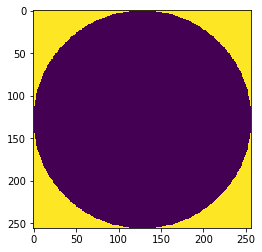

In [3]:
#create mask
mask2 = np.ones((400, 400), dtype=np.uint8)
for i in range(400):
    for j in range(400):
        if ((i - 200)**2 + (j - 200)**2) < 128**2:
            mask2[i, j] = 0
mask2 = mask2[72:-72, 72:-72]
plt.imshow(mask2)

In [8]:
class SimTest(Dataset):
    def __init__(self, root='./data/noisy_gaussians', noise_level='1.0'):
        self.frequencies = ['100', '143', '217', '353', '545']
        self.noise_level = noise_level
        
        self.images = []
        for i in range(1, 101):
            noise_level_ = noise_level.replace('.', '_')
            imgs = [self.open_image(f'{root}/sqg{f}p{noise_level_}/scq{i}_{f}p{noise_level}g.gif')
                    for f in self.frequencies]
            self.images.append(np.array(imgs))

    def __len__(self):
        return len(self.images)
    
    def open_image(self, path):
        img = Image.open(path).convert('L')
        img = np.asarray(img, dtype=np.float32).copy() / 255
        img = img[72:-72, 72:-72]
        img[mask2 == 1] = -1
        img = img[::2, ::2]
        return img
    
    def __getitem__(self, idx):
        return self.images[idx]

# Test on generated data

In [21]:
device = 0
checkpoint_name = './checkpoints/v2_128_oleg_14/net_best.pt'
threshold = 0.4

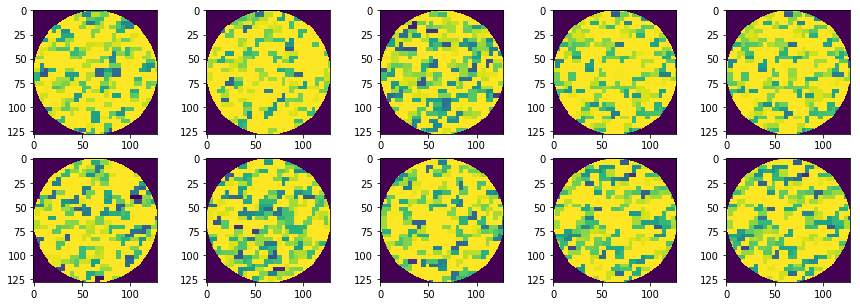

In [12]:
test_dataset = SimTest()

fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(test_dataset[i][j], vmin=0, vmax=0.5)

In [13]:
model = resnet18(num_classes=1).to(device)
model.load_state_dict(torch.load(checkpoint_name))
model.eval();

In [22]:
acc = []
for noise_level in '1.0', '2.0', '3.0', '5.0', '10.0':
    dataset = SimTest(noise_level=noise_level)
    batch = torch.from_numpy(np.array([dataset[i] for i in range(100)])).to(device)
    out = model(batch)
    mean_acc = (out > threshold).float().mean().cpu().numpy()
    mean_std = (out > threshold).float().std().cpu().numpy()
    print(f'S/N: {noise_level}, mean={mean_acc:.2f}, std={mean_std:.2f}')
    acc.append(mean_acc)

S/N: 1.0, mean=0.02, std=0.14
S/N: 2.0, mean=0.24, std=0.43
S/N: 3.0, mean=0.52, std=0.50
S/N: 5.0, mean=0.92, std=0.27
S/N: 10.0, mean=0.98, std=0.14


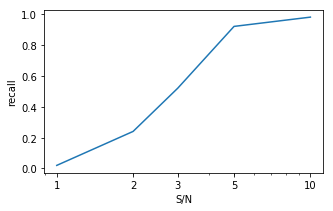

In [23]:
fig, ax = plt.subplots(1, figsize=(5, 3))
ax.plot([1, 2, 3, 5, 10], acc)
ax.set_xlabel('S/N')
ax.set_ylabel('recall')

ax.set_xscale('log')
ax.set_xticks([1, 2, 3, 5, 10])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('sim_recall_logscale.eps', format='eps')

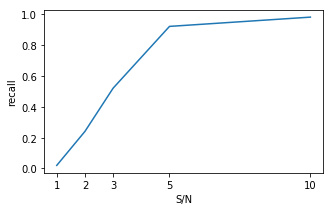

In [24]:
fig, ax = plt.subplots(1, figsize=(5, 3))
ax.plot([1, 2, 3, 5, 10], acc)
ax.set_xlabel('S/N')
ax.set_ylabel('recall')

ax.set_xticks([1, 2, 3, 5, 10])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig('sim_recall_linscale.eps', format='eps')